# Library

In [5]:
!gdown 1y8xhCM_rVCgxOPSF3VtVkFxnwxtBlH0x

'gdown' is not recognized as an internal or external command,
operable program or batch file.


In [9]:
import torch
from torch import nn
# from adopt import ADOPT
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision.datasets import FashionMNIST
import torchvision.transforms as transforms
import numpy as np
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
torch.manual_seed(42)

# Data

In [10]:
batch_size = 512
num_epochs = 100
lr = 0.001

In [11]:
train_dataset = FashionMNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
train_loader = DataLoader(train_dataset, batch_size, shuffle=True)
test_dataset = FashionMNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())
test_loader = DataLoader(test_dataset, batch_size)

# Model

In [12]:
class MLP(nn.Module):
    def __init__(self, input_dims, hidden_dims, output_dims):
        super(MLP, self).__init__()
        self.layer1 = nn.Linear(input_dims, hidden_dims)
        self.layer2 = nn.Linear(hidden_dims, hidden_dims)
        self.layer3 = nn.Linear(hidden_dims, hidden_dims)
        self.layer4 = nn.Linear(hidden_dims, hidden_dims)
        self.layer5 = nn.Linear(hidden_dims, hidden_dims)
        self.output = nn.Linear(hidden_dims, output_dims)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = nn.Flatten()(x)
        x = self.layer1(x)
        x = self.sigmoid(x)
        x = self.layer2(x)
        x = self.sigmoid(x)
        x = self.layer3(x)
        x = self.sigmoid(x)
        x = self.layer4(x)
        x = self.sigmoid(x)
        x = self.layer5(x)
        x = self.sigmoid(x)
        out = self.output(x)
        return out

In [13]:
model = MLP(input_dims=784, hidden_dims=128, output_dims=10).to(device)
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [10]:
train_losses = []
train_acc = []
val_losses = []
val_acc = []

for epoch in range(num_epochs):
    model.train()
    t_loss = 0
    t_acc = 0
    cnt = 0
    for X, y in train_loader:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        outputs = model(X)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()
        t_loss += loss.item()
        t_acc += (outputs.argmax(1) == y).float().sum().item()
        cnt += len(y)
        
    t_loss /= len(train_loader)
    train_losses.append(t_loss)
    t_acc /= cnt 
    train_acc.append(t_acc)
    
    model.eval()
    v_loss = 0
    v_acc = 0
    cnt = 0
    
    with torch.no_grad():
        for X, y in test_loader:
            X, y = X.to(device), y.to(device)
            outputs = model(X)
            loss = criterion(outputs, y)
            v_loss += loss.item()
            v_acc += (outputs.argmax(1) == y).float().sum().item()
            cnt += len(y)
        
    v_loss /= len(test_loader)
    val_losses.append(v_loss)
    v_acc /= cnt
    val_acc.append(v_acc)
    
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {t_loss:.4f}, Train Acc: {t_acc:.4f}, Val Loss: {v_loss:.4f}, Val Acc: {v_acc:.4f}')

torch.save(model.state_dict(), 'model.pth')
        

Epoch 1/100, Train Loss: 2.0233, Train Acc: 0.1613, Val Loss: 1.6895, Val Acc: 0.1999
Epoch 2/100, Train Loss: 1.5800, Train Acc: 0.2655, Val Loss: 1.4563, Val Acc: 0.3730
Epoch 3/100, Train Loss: 1.2253, Train Acc: 0.4554, Val Loss: 1.0929, Val Acc: 0.5223
Epoch 4/100, Train Loss: 0.9613, Train Acc: 0.5902, Val Loss: 0.8670, Val Acc: 0.6651
Epoch 5/100, Train Loss: 0.8068, Train Acc: 0.6762, Val Loss: 0.7778, Val Acc: 0.6903
Epoch 6/100, Train Loss: 0.7159, Train Acc: 0.7367, Val Loss: 0.6908, Val Acc: 0.7676
Epoch 7/100, Train Loss: 0.6423, Train Acc: 0.7799, Val Loss: 0.6395, Val Acc: 0.7844
Epoch 8/100, Train Loss: 0.5863, Train Acc: 0.7973, Val Loss: 0.5999, Val Acc: 0.7959
Epoch 9/100, Train Loss: 0.5442, Train Acc: 0.8085, Val Loss: 0.5674, Val Acc: 0.8003
Epoch 10/100, Train Loss: 0.5118, Train Acc: 0.8161, Val Loss: 0.5392, Val Acc: 0.8072
Epoch 11/100, Train Loss: 0.4869, Train Acc: 0.8237, Val Loss: 0.5183, Val Acc: 0.8114
Epoch 12/100, Train Loss: 0.4629, Train Acc: 0.8335,

# Inference

In [14]:
import torch
import numpy as np

model = MLP(input_dims=784, hidden_dims=128, output_dims=10).to(device)
model.load_state_dict(torch.load('model.pth'))

def read_idx(filename):
    with open(filename, 'rb') as f:
        magic, num_images, rows, cols = np.fromfile(f, dtype=np.dtype('>i4'), count=4)
        images = np.fromfile(f, dtype=np.uint8).reshape(num_images, rows, cols)
    return images

test_images = read_idx('data/FashionMNIST/raw/t10k-images-idx3-ubyte')
test_images = test_images.astype(np.float32) / 255.0  # Normalize
test_images = test_images.reshape(-1, 784)  # Flatten
test_images_tensor = torch.tensor(test_images).to(device)

model.eval()
with torch.no_grad():
    predictions = model(test_images_tensor)

predicted_classes = torch.argmax(predictions, dim=1)
print(predicted_classes.cpu().numpy())

[9 2 1 ... 8 1 5]


In [16]:
print("Accuracy: ", (predicted_classes.cpu().numpy() == test_dataset.targets.numpy()).mean())

Accuracy:  0.8729


# Visualization on Inference

Overall Accuracy: 0.8729


C:\Users\USER\AppData\Local\Temp\ipykernel_19244\3482372989.py:39: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


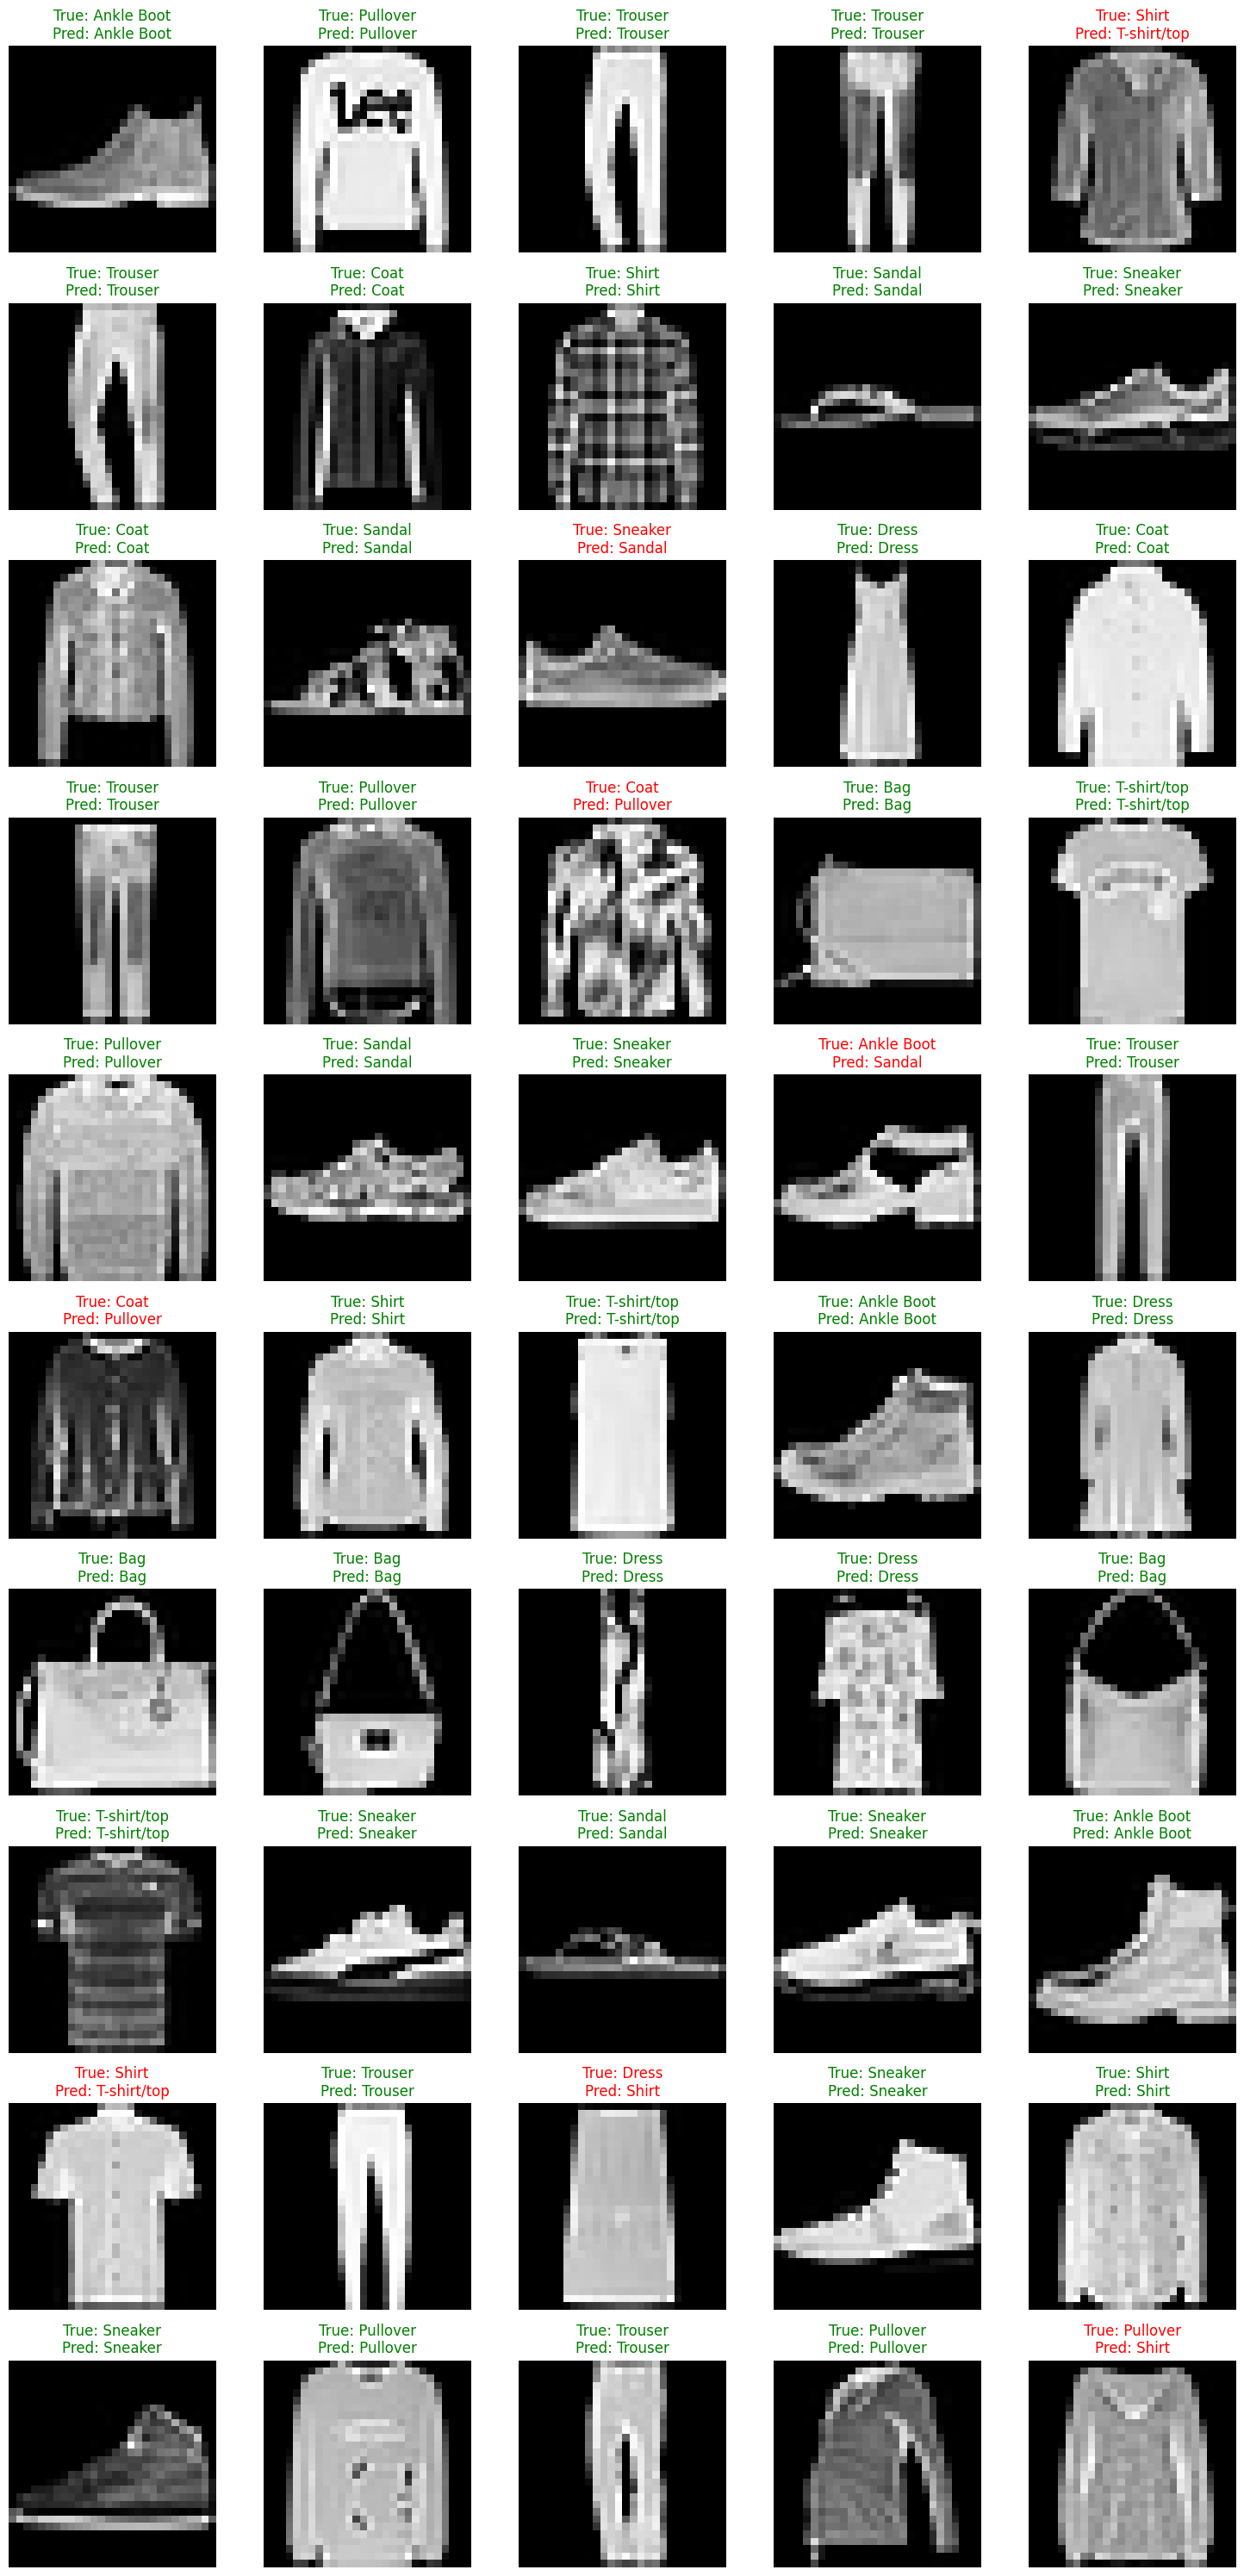

T-shirt/top Accuracy: 0.8030
Trouser Accuracy: 0.9540
Pullover Accuracy: 0.7630
Dress Accuracy: 0.8680
Coat Accuracy: 0.8270
Sandal Accuracy: 0.9710
Shirt Accuracy: 0.7000
Sneaker Accuracy: 0.9490
Bag Accuracy: 0.9590
Ankle Boot Accuracy: 0.9350


In [21]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms

# Class name
class_names = [
    'T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
    'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot'
]

def read_idx_images(filename):
    with open(filename, 'rb') as f:
        magic, num_images, rows, cols = np.fromfile(f, dtype=np.dtype('>i4'), count=4)
        images = np.fromfile(f, dtype=np.uint8).reshape(num_images, rows, cols)
    return images

def read_idx_labels(filename):
    with open(filename, 'rb') as f:
        magic, num_labels = np.fromfile(f, dtype=np.dtype('>i4'), count=2)
        labels = np.fromfile(f, dtype=np.uint8)
    return labels

def visualize_predictions(images, true_labels, predicted_labels, num_images=50):
    plt.figure(figsize=(3*5, 3*10), constrained_layout=True)
    for i in range(num_images):
        plt.subplot(10, 5, i+1)
        plt.imshow(images[i], cmap='gray')
        
        color = 'green' if true_labels[i] == predicted_labels[i] else 'red'
        
        plt.title(
            f'True: {class_names[true_labels[i]]}\n'
            f'Pred: {class_names[predicted_labels[i]]}', 
            color=color
        )
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Load model
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = MLP(input_dims=784, hidden_dims=128, output_dims=10).to(device)
model.load_state_dict(torch.load('model.pth'))

# Load test images and labels
test_images = read_idx_images('data/FashionMNIST/raw/t10k-images-idx3-ubyte')
true_labels = read_idx_labels('data/FashionMNIST/raw/t10k-labels-idx1-ubyte')

# Preprocess images
test_images = test_images.astype(np.float32) / 255.0  # Normalize
test_images_tensor = torch.tensor(test_images.reshape(-1, 784)).to(device)

# Perform inference
model.eval()
with torch.no_grad():
    predictions = model(test_images_tensor)

predicted_classes = torch.argmax(predictions, dim=1).cpu().numpy()

accuracy = (predicted_classes == true_labels).mean()
print(f"Overall Accuracy: {accuracy:.4f}")

# Visualize some predictions
visualize_predictions(test_images, true_labels, predicted_classes)

# Detailed accuracy for each class
class_accuracy = {}
for i, class_name in enumerate(class_names):
    class_mask = true_labels == i
    class_acc = (predicted_classes[class_mask] == true_labels[class_mask]).mean()
    class_accuracy[class_name] = class_acc
    print(f"{class_name} Accuracy: {class_acc:.4f}")